# LSTM 써보기    
이것은 모두의연구소 AIFFEL 부산2기 아이펠톤 팀 레드존의 이창현이 센서 데이터를 LSTM으로 학습시켜 보려고 하는 노트북입니다.  
일단 라벨링 방식에 따라 두 데이터레이블을 병합할 필요가 있습니다. 근데 하나로 일단 돌려도 괜찮습니다.  
LSTM은 시퀀스에 대한 것으로, 여기서는 시계열 데이터를 쓰고 있으므로 그걸 특정 길이로 잘라 쓰도록 합니다. 그렇다면 결측치는 어떻게 처리할까요? 일단 linear하게 interpolation을 하도록 합니다.  

# 업데이트 로그

2022-11-08 작업중/작업 예정
- 보간법 (interpolation)에서 라벨링 오류 수정 : 날짜와 라벨이 다른 경우 0, 1이 아닌 소수점 라벨이 생기는데, 이것을 pandas.groupby를 이용해 처리하자 [스택 오버플로우 - fillna using groupby](https://stackoverflow.com/questions/46391128/pandas-fillna-using-groupby)     
- 데이터 normalization하고, 편차 넣자. 적당히 고정값으로 한번만 해주자.
- 5개 지점 병합한 걸 통째로 모델에 넣기(feature 15개로 늘리고, 지점도 사실상 feature로 활용하는 셈이다. 물론 feature를 one-hot encode해도 별 차이는 없다) : 이건 일단 모델 좀 돌리고 나중에 하자.  
- label 예외처리: 문제 해결하고 삭제해야됨 -> 이거 dt_index 불러올때 시간도 넣어서 그렇다. dt_index[:-1]이면 해결완료 -> 그래도 해결이 안되네
- 적조속보 있는 데이터 다 긁어와서 학습시켜보기  



2022-11-07 11:44 디버깅 및 missing value 처리 완료. sequence로 전환 작업중 -> 완료
13:35 간단한 LSTM모델 돌려보기 완료.   
22:54 5개 지점 데이터 병합해서 다시 돌립니다. 코랩으로 옮겼습니다.

2022-11-04 16:20 class Lin_Interpolate 디버깅중... -> datetime이나, timestamp 너무 애매합니다. 그냥 앞으로는 ['Year', 'mm', 'dd', 'hh'] integer 4개로 통일합니다.

## 일시 처리 방법:
이 노트북에서는 날짜+시간까지 int로 전환하여 처리합니다.
시간 연산 할 때에는 pd.Timestamp로 입력하고, 다시 데이터프레임에서는 integer를 둡니다.
```python
#convert between pandas.Timestamp <-> integers
a=pd.Timestamp(2019, 1, 1)
print(a, type(a), a.year, a.month, a.day, a.hour, type(a.year))

#add 1 hour
a=pd.Timestamp(2019, 1, 1)
a+pd.Timedelta(1, 'h')
```

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ds = pd.read_csv('data/17-19실측(예찰선)labeled.csv', encoding='euc-kr')
ds=pd.concat([ds, pd.read_csv('data/20-220930실측(예찰선)labeled.csv', encoding='euc-kr')])


In [3]:
print(ds['일시'].dtype, type(ds['일시'].values[0]))

object <class 'str'>


In [4]:
ds['year']=ds['일시'].apply(lambda x: pd.Timestamp(x).year)
ds['mm']=ds['일시'].apply(lambda x: pd.Timestamp(x).month)
ds['dd']=ds['일시'].apply(lambda x: pd.Timestamp(x).day)
ds['hh']=ds['일시'].apply(lambda x: pd.Timestamp(x).hour)

In [5]:
ds

,Unnamed: 0,지점,일시,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),적조발생,year,mm,dd,hh
0,0,추자도,2017-01-01 1:00,4.2,306.0,11.0,15.8,0.0,0,2017,1,1,1
1,1,추자도,2017-01-01 2:00,2.6,315.0,10.8,15.7,0.0,0,2017,1,1,2
2,2,추자도,2017-01-01 3:00,2.5,307.0,10.8,15.6,0.0,0,2017,1,1,3
3,3,추자도,2017-01-01 4:00,1.5,331.0,11.0,15.6,0.0,0,2017,1,1,4
4,4,추자도,2017-01-01 5:00,4.2,331.0,10.8,15.6,0.0,0,2017,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113905,113905,울산,2022-09-30 19:00,2.9,139.0,24.0,25.3,0.0,0,2022,9,30,19
113906,113906,울산,2022-09-30 20:00,3.2,144.0,23.7,25.2,0.0,0,2022,9,30,20
113907,113907,울산,2022-09-30 21:00,2.7,144.0,23.7,25.1,0.0,0,2022,9,30,21
113908,113908,울산,2022-09-30 22:00,1.8,179.0,23.4,25.1,0.0,0,2022,9,30,22


# 1. 전처리

## 결측치 missing values
일단 linear interpolation을 하도록 합니다. 메모리가 크지 않기 때문에 데이터셋을 포함하는 그 어떤 클래스를 만들어서 쓰겠습니다.  
그 전에, 연속적으로 빠진 일시를 파악합니다.

In [6]:
ds0=ds.loc[ds['지점']=='통영']
ds0

,Unnamed: 0,지점,일시,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),적조발생,year,mm,dd,hh
99918,99918,통영,2017-01-01 1:00,NaN,NaN,8.8,17.5,0.0,0,2017,1,1,1
99919,99919,통영,2017-01-01 2:00,NaN,NaN,8.8,17.5,0.0,0,2017,1,1,2
99920,99920,통영,2017-01-01 3:00,NaN,NaN,9.1,17.5,0.0,0,2017,1,1,3
99921,99921,통영,2017-01-01 4:00,NaN,NaN,9.1,17.4,0.0,0,2017,1,1,4
99922,99922,통영,2017-01-01 5:00,NaN,NaN,8.5,17.4,0.0,0,2017,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69093,69093,통영,2022-09-30 19:00,2.2,230.0,23.8,24.6,0.0,0,2022,9,30,19
69094,69094,통영,2022-09-30 20:00,2.6,227.0,24.1,24.7,0.0,0,2022,9,30,20
69095,69095,통영,2022-09-30 21:00,3.5,274.0,23.8,24.1,0.0,0,2022,9,30,21
69096,69096,통영,2022-09-30 22:00,3.4,269.0,23.6,23.9,0.0,0,2022,9,30,22


In [7]:
ds0.reset_index(inplace=True)
df_default_index=['지점',  'year', 'mm', 'dd', 'hh', '풍속(m/s)', '풍향(deg)', '기온(°C)', '수온(°C)', '강수량(mm)', '적조발생']
ds0=ds0[df_default_index]
ds0

,지점,year,mm,dd,hh,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),적조발생
0,통영,2017,1,1,1,NaN,NaN,8.8,17.5,0.0,0
1,통영,2017,1,1,2,NaN,NaN,8.8,17.5,0.0,0
2,통영,2017,1,1,3,NaN,NaN,9.1,17.5,0.0,0
3,통영,2017,1,1,4,NaN,NaN,9.1,17.4,0.0,0
4,통영,2017,1,1,5,NaN,NaN,8.5,17.4,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
46980,통영,2022,9,30,19,2.2,230.0,23.8,24.6,0.0,0
46981,통영,2022,9,30,20,2.6,227.0,24.1,24.7,0.0,0
46982,통영,2022,9,30,21,3.5,274.0,23.8,24.1,0.0,0
46983,통영,2022,9,30,22,3.4,269.0,23.6,23.9,0.0,0


In [8]:
dt_index=['year', 'mm', 'dd', 'hh']

class Lin_Interpolate:
    """Linear interpolate nan datetimes
    """
    def __init__(self, dataframe):
        """receive 'datetime dateframe'. It should include
        yyyy, mm, dd, hh as columns of which type is int64"""
        self.dtd=dataframe
        self.time_start=self.dtd[dt_index].loc[0].to_numpy()
        self.time_end=self.dtd[dt_index].loc[len(self.dtd)-1].to_numpy()
    
    def check_sorted(self):
        #return (self.dtd.sort_values(by=dt_index,ascending=True) == self.dtd).all()
        if (self.dtd.sort_values(by=dt_index,ascending=True)['dd'] == self.dtd['dd']).all() \
            and (self.dtd.sort_values(by=dt_index,ascending=True)['year'] == self.dtd['year']).all()\
            and (self.dtd.sort_values(by=dt_index,ascending=True)['mm'] == self.dtd['mm']).all():
            return True
        else:
            return False
    def next_hour(self, array):
        '''def next_day(self, array)
        return next day as numpy ndarray.
        '''
        next_hour=pd.Timestamp(*array)+pd.Timedelta(1, 'h')
        return np.array([next_hour.year, next_hour.month, next_hour.day, next_hour.hour])
        
    
    def missing_hours(self, t0, t1):
        t=t0
        missing_hours_list=[]
        missing_hours_number=0
        missing_hours_df=pd.DataFrame()

        for idx in range(len(self.dtd)):
            target_date=self.dtd.loc[idx][dt_index].astype(int).values
            while pd.Timestamp(*t)<=pd.Timestamp(*target_date):
                if (t==target_date).all():
                    t=self.next_hour(t)
                else:
                    missing_hours_list.append(t)
                    t=self.next_hour(t)
                    missing_hours_number+=1
        print('total {} missing hours found'.format(missing_hours_number))
        
        return pd.DataFrame(missing_hours_list, columns=dt_index)

    def fill_hours(self, target_df):
        return pd.concat([target_df, self.missing_hours(self.time_start, self.time_end)])
    
#ds0=ds.loc[ds['지점']=='추자도']

lin_interpolate=Lin_Interpolate(ds0)
lin_interpolate.check_sorted()

True

## validation
약 3년은 $365 \times 24 \times 3=26280$시간이므로, 이와 비슷한 수가 나와야 한다.

In [9]:
print(len(ds0))
ds0=lin_interpolate.fill_hours(ds0)
print(len(ds0))

46985
total 3390 missing hours found
50375


## interpolate 등
- 시간에 대해 sort하고 index, column등을 정리합니다.
- label의 경우 날짜별로 넣고 있기 때문에 날짜별로 groupby하고 bfill, ffill을 활용합니다.
- linear interpolate하고, 
- linear interpolate로 채워지지 않는 '지점' 등을 채워 넣고
- 결측치가 있는 row를 제거합니다. (interpolate는 데이터포인트 사이만 채우기 때문에, 시작이나 끝 부분의 결측치는 사라지지 않습니다.)

In [10]:
df_default_index=['지점',  'year', 'mm', 'dd', 'hh', '풍속(m/s)', '풍향(deg)', '기온(°C)', '수온(°C)', '강수량(mm)', '적조발생']

#reset index
ds0.sort_values(by=dt_index, inplace=True)
ds0.reset_index(inplace=True, drop=True) #'if drop'=True, drop current index. if False, it becomes a new column.
ds0=ds0[df_default_index]

ds0

,지점,year,mm,dd,hh,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),적조발생
0,통영,2017,1,1,1,NaN,NaN,8.8,17.5,0.0,0.0
1,통영,2017,1,1,2,NaN,NaN,8.8,17.5,0.0,0.0
2,통영,2017,1,1,3,NaN,NaN,9.1,17.5,0.0,0.0
3,통영,2017,1,1,4,NaN,NaN,9.1,17.4,0.0,0.0
4,통영,2017,1,1,5,NaN,NaN,8.5,17.4,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
50370,통영,2022,9,30,19,2.2,230.0,23.8,24.6,0.0,0.0
50371,통영,2022,9,30,20,2.6,227.0,24.1,24.7,0.0,0.0
50372,통영,2022,9,30,21,3.5,274.0,23.8,24.1,0.0,0.0
50373,통영,2022,9,30,22,3.4,269.0,23.6,23.9,0.0,0.0


### label 채워넣기
https://stackoverflow.com/questions/46391128/pandas-fillna-using-groupby 를 참고함

In [11]:
ds0['적조발생'] = ds0.groupby(dt_index, sort=False)['적조발생']\
                .apply(lambda x: x.ffill().bfill())

통영 50까지의 데이터는 두 케이스(interpolate가 되는 경우와 되지 않는 경우)의 결측치가 모두 있습니다.

In [12]:
print(ds0[:50])

     지점  year  mm  dd  hh  풍속(m/s)  풍향(deg)  기온(°C)  수온(°C)  강수량(mm)  적조발생
0    통영  2017   1   1   1      NaN      NaN     8.8    17.5      0.0   0.0
1    통영  2017   1   1   2      NaN      NaN     8.8    17.5      0.0   0.0
2    통영  2017   1   1   3      NaN      NaN     9.1    17.5      0.0   0.0
3    통영  2017   1   1   4      NaN      NaN     9.1    17.4      0.0   0.0
4    통영  2017   1   1   5      NaN      NaN     8.5    17.4      0.0   0.0
5    통영  2017   1   1   6      NaN      NaN     8.4    17.3      0.0   0.0
6    통영  2017   1   1   7      NaN      NaN     8.4    17.3      0.0   0.0
7    통영  2017   1   1   8      NaN      NaN     8.2    17.3      0.0   0.0
8    통영  2017   1   1   9      NaN      NaN     8.4    17.3      0.0   0.0
9    통영  2017   1   1  10      NaN      NaN     8.5    17.3      0.0   0.0
10   통영  2017   1   1  11      NaN      NaN     8.3    17.3      0.0   0.0
11   통영  2017   1   1  12      NaN      NaN     8.3    17.2      0.0   0.0
12   통영  2017   1   1  13

### interpolation:
pandas에 이미 interpolation이 있어 쉽게 됩니다.

In [13]:
#missing values count
print(ds0.isna().sum())

지점         3390
year          0
mm            0
dd            0
hh            0
풍속(m/s)    4337
풍향(deg)    4336
기온(°C)     3441
수온(°C)     3490
강수량(mm)    3390
적조발생       3390
dtype: int64


In [14]:
ds0.interpolate(limit_area='inside', inplace=True)
ds0[35:45]

,지점,year,mm,dd,hh,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),적조발생
35,통영,2017,1,2,12,NaN,NaN,11.10,16.6,0.0,0.0
36,통영,2017,1,2,13,NaN,NaN,11.20,16.8,0.0,0.0
37,통영,2017,1,2,14,NaN,NaN,11.80,16.8,0.0,0.0
38,통영,2017,1,2,15,NaN,NaN,12.20,16.8,0.0,0.0
39,통영,2017,1,2,16,5.8,249.0,12.90,16.9,0.0,0.0
40,NaN,2017,1,2,17,5.9,255.0,12.85,16.9,0.0,0.0
41,통영,2017,1,2,18,6.0,261.0,12.80,16.9,0.0,0.0
42,통영,2017,1,2,19,6.6,263.0,13.00,16.9,0.0,0.0
43,통영,2017,1,2,20,7.1,268.0,13.20,16.8,0.0,0.0
44,통영,2017,1,2,21,8.6,299.0,13.50,16.8,0.0,0.0


In [15]:
print(ds0.isna().sum())

지점         3390
year          0
mm            0
dd            0
hh            0
풍속(m/s)      39
풍향(deg)      39
기온(°C)        0
수온(°C)        0
강수량(mm)       0
적조발생          0
dtype: int64


40인덱스, 2017년 1월 2일 17시의 결측치가 interpolate됐습니다. 하지만 '지점'은 문자열이라 되지 않습니다. 이것은 dataframe.fillna() 의 method를 ffill로 합니다. 그러면 앞의 값으로 채울 수 있습니다.

In [16]:
ds0['지점']=ds0['지점'].fillna(method='ffill')
ds0[35:45]

,지점,year,mm,dd,hh,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),적조발생
35,통영,2017,1,2,12,NaN,NaN,11.10,16.6,0.0,0.0
36,통영,2017,1,2,13,NaN,NaN,11.20,16.8,0.0,0.0
37,통영,2017,1,2,14,NaN,NaN,11.80,16.8,0.0,0.0
38,통영,2017,1,2,15,NaN,NaN,12.20,16.8,0.0,0.0
39,통영,2017,1,2,16,5.8,249.0,12.90,16.9,0.0,0.0
40,통영,2017,1,2,17,5.9,255.0,12.85,16.9,0.0,0.0
41,통영,2017,1,2,18,6.0,261.0,12.80,16.9,0.0,0.0
42,통영,2017,1,2,19,6.6,263.0,13.00,16.9,0.0,0.0
43,통영,2017,1,2,20,7.1,268.0,13.20,16.8,0.0,0.0
44,통영,2017,1,2,21,8.6,299.0,13.50,16.8,0.0,0.0


In [17]:
print(ds0.isna().sum(), '\n total_rows: ',len(ds0))

지점          0
year        0
mm          0
dd          0
hh          0
풍속(m/s)    39
풍향(deg)    39
기온(°C)      0
수온(°C)      0
강수량(mm)     0
적조발생        0
dtype: int64 
 total_rows:  50375


In [18]:
#drop rows with missing values
ds0.dropna(inplace=True)
print(ds0.isna().sum(), '\n total_rows: ',len(ds0))

지점         0
year       0
mm         0
dd         0
hh         0
풍속(m/s)    0
풍향(deg)    0
기온(°C)     0
수온(°C)     0
강수량(mm)    0
적조발생       0
dtype: int64 
 total_rows:  50336


## 각 지역에 대해 처리
마지막 ds0.dropna(inplace=True)와 지점명 interpolation을 빼고 한 지역에 대해 처리한 것을 반복하고, 데이터프레임을 통합합니다. 이후 ds0.dropna(inplace=True) 수행.  


먼저 시작일/종료일을 하나로 맞춰야 합니다.  
라벨(적조 발생여부)은 반복되므로 일단 분리했다가 마지막에 다시 합칩니다.

In [19]:
locations=['거문도', '울산', '거제도', '통영', '추자도']

for pos in locations:
    ds0=ds.loc[ds['지점']==pos]
    print(ds0['일시'])

24395     2017-01-01 1:00
24396     2017-01-01 2:00
24397     2017-01-01 3:00
24398     2017-01-01 4:00
24399     2017-01-01 5:00
               ...       
46169    2022-09-30 19:00
46170    2022-09-30 20:00
46171    2022-09-30 21:00
46172    2022-09-30 22:00
46173    2022-09-30 23:00
Name: 일시, Length: 49355, dtype: object
50110      2017-01-01 1:00
50111      2017-01-01 2:00
50112      2017-01-01 3:00
50113      2017-01-01 4:00
50114      2017-01-01 5:00
                ...       
113905    2022-09-30 19:00
113906    2022-09-30 20:00
113907    2022-09-30 21:00
113908    2022-09-30 22:00
113909    2022-09-30 23:00
Name: 일시, Length: 47320, dtype: object
74526     2017-01-01 1:00
74527     2017-01-01 2:00
74528     2017-01-01 3:00
74529     2017-01-01 4:00
74530     2017-01-01 5:00
               ...       
91001    2022-09-30 19:00
91002    2022-09-30 20:00
91003    2022-09-30 21:00
91004    2022-09-30 22:00
91005    2022-09-30 23:00
Name: 일시, Length: 47300, dtype: object
99918     2017

다행히 다 같아서 맞출 필요가 없습니다.

In [193]:

for pos in locations:
    ds0=ds.loc[ds['지점']==pos]

    ds0.reset_index(inplace=True)
    df_default_index=['지점',  'year', 'mm', 'dd', 'hh', '풍속(m/s)', '풍향(deg)', '기온(°C)', '수온(°C)', '강수량(mm)', '적조발생']
    ds0=ds0[df_default_index]

    lin_interpolate=Lin_Interpolate(ds0)

    print('previous num rows: {} in location {}'.format(len(ds0), pos))
    ds0=lin_interpolate.fill_hours(ds0)
    print('num rows:', len(ds0))

    df_default_index=['지점',  'year', 'mm', 'dd', 'hh', '풍속(m/s)', '풍향(deg)', '기온(°C)', '수온(°C)', '강수량(mm)', '적조발생']

    #reset index
    ds0.sort_values(by=dt_index, inplace=True)
    ds0.reset_index(inplace=True, drop=True) #'if drop'=True, drop current index. if False, it becomes a new column.
    ds0=ds0[df_default_index]

    ds0['적조발생'] = ds0.groupby(dt_index[:-1], sort=False)['적조발생']\
                    .apply(lambda x: x.ffill().bfill())

    ds0.interpolate(limit_area='inside', inplace=True)
    
    label=ds0['적조발생']
    ds0.drop(columns=['지점', '적조발생', 'year', 'mm', 'dd', 'hh'], inplace=True)
    
    if pos==locations[0]:
        df_merged=ds0
    else:
        df_merged=pd.concat([df_merged, ds0], axis=1)

#merge label
df_merged_store=pd.concat([df_merged, label], axis=1)


previous num rows: 49355 in location 거문도
total 1020 missing hours found
num rows: 50375
previous num rows: 47320 in location 울산
total 3055 missing hours found
num rows: 50375
previous num rows: 47300 in location 거제도
total 3075 missing hours found
num rows: 50375
previous num rows: 46985 in location 통영
total 3390 missing hours found
num rows: 50375
previous num rows: 46929 in location 추자도
total 3446 missing hours found
num rows: 50375


In [437]:
df_merged=df_merged_store

In [438]:
print(df_merged)
df_merged.dropna(inplace=True)
print(df_merged.isna().sum(), '\n total_rows: ',len(df_merged))

        풍속(m/s)   풍향(deg)    기온(°C)    수온(°C)   강수량(mm)   풍속(m/s)   풍향(deg)  \
0     -0.846358  0.903430 -0.460595 -0.297487 -0.124668 -1.539878  0.752017   
1     -0.308964  0.861089 -0.404756 -0.276128 -0.124668 -1.661737  0.652532   
2     -0.428385  0.945770 -0.348918 -0.297487 -0.124668 -1.448484  0.534960   
3     -0.338819  0.827217 -0.293080 -0.404279 -0.124668 -1.539878  0.652532   
4      0.168719  1.064324 -0.320999 -0.468355 -0.124668  0.074754  0.842458   
...         ...       ...       ...       ...       ...       ...       ...   
50331 -1.712158  0.115895  0.879527  1.218967 -0.124668 -1.082907 -0.405622   
50332 -1.353896  0.183640  0.893486  1.176250 -0.124668 -0.991512 -0.360402   
50333 -1.353896  0.454619  0.879527  1.176250 -0.124668 -1.143836 -0.360402   
50334 -1.234475  0.573173  0.837648  1.261684 -0.124668 -1.418019 -0.043860   
50335 -1.144909  0.615514  0.837648  1.283042 -0.124668 -1.387554  0.146065   

         기온(°C)    수온(°C)   강수량(mm)  ...   풍향(deg) 

### normalize
이것 역시 판다스를 이용해서 쉽게 되네요. https://stackoverflow.com/questions/46391128/pandas-fillna-using-groupby

In [439]:
df_merged.iloc[:,:-1]

,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),...,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm)
0,-0.846358,0.903430,-0.460595,-0.297487,-0.124668,-1.539878,0.752017,-0.658575,-0.665820,-0.134178,...,-0.029573,0.586254,-0.442772,-0.243601,-0.150869,-1.353779,1.551810,-0.364254,-0.500266,-0.112367
1,-0.308964,0.861089,-0.404756,-0.276128,-0.124668,-1.661737,0.652532,-0.588377,-0.620489,-0.134178,...,0.001133,0.638984,-0.449676,-0.243601,-0.150869,-0.406414,-1.337830,-0.391642,-0.519119,-0.112367
2,-0.428385,0.945770,-0.348918,-0.297487,-0.124668,-1.448484,0.534960,-0.616456,-0.643154,-0.134178,...,0.031840,0.691715,-0.456580,-0.243601,-0.150869,-0.161932,1.378432,-0.377948,-0.519119,-0.112367
3,-0.338819,0.827217,-0.293080,-0.404279,-0.124668,-1.539878,0.652532,-0.546258,-0.665820,-0.134178,...,0.216079,0.709292,-0.428963,-0.243601,-0.150869,-0.559215,1.386688,-0.323173,-0.519119,-0.112367
4,0.168719,1.064324,-0.320999,-0.468355,-0.124668,0.074754,0.842458,-0.447980,-0.688485,-0.134178,...,0.369611,0.753234,-0.401346,-0.262635,-0.150869,0.113109,-1.329574,-0.336867,-0.500266,-0.112367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50331,-1.712158,0.115895,0.879527,1.218967,-0.124668,-1.082907,-0.405622,0.899828,1.260715,-0.134178,...,-1.135006,0.419274,1.062370,1.222006,-0.150869,-1.537140,-1.329574,0.881887,1.196504,-0.112367
50332,-1.353896,0.183640,0.893486,1.176250,-0.124668,-0.991512,-0.360402,0.857709,1.238050,-0.134178,...,-1.012180,0.392909,1.103796,1.241040,-0.150869,-1.384339,-1.222244,0.553234,1.026827,-0.112367
50333,-1.353896,0.454619,0.879527,1.176250,-0.124668,-1.143836,-0.360402,0.857709,1.215385,-0.134178,...,-0.735822,0.805964,1.062370,1.126837,-0.150869,-1.567700,1.477505,0.347826,0.970268,-0.112367
50334,-1.234475,0.573173,0.837648,1.261684,-0.124668,-1.418019,-0.043860,0.815590,1.215385,-0.134178,...,-0.766528,0.762022,1.034753,1.088769,-0.150869,-1.567700,1.361919,0.690173,0.932562,-0.112367


In [440]:

df_merged.iloc[:,:-1]=(df_merged.iloc[:,:-1]-df_merged.iloc[:,:-1].mean())/df_merged.iloc[:,:-1].std()
#df_merged.iloc[:,:-1]=(df_merged.iloc[:,:-1]-df_merged.iloc[:,:-1].mean())
#df_merged.iloc[:,:-1]=(df_merged.iloc[:,:-1])/df_merged.iloc[:,:-1].std()

df_merged

,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),...,풍향(deg),기온(°C),수온(°C),강수량(mm),풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),적조발생
0,-0.846358,0.903430,-0.460595,-0.297487,-0.124668,-1.539878,0.752017,-0.658575,-0.665820,-0.134178,...,0.586254,-0.442772,-0.243601,-0.150869,-1.353779,1.551810,-0.364254,-0.500266,-0.112367,0.0
1,-0.308964,0.861089,-0.404756,-0.276128,-0.124668,-1.661737,0.652532,-0.588377,-0.620489,-0.134178,...,0.638984,-0.449676,-0.243601,-0.150869,-0.406414,-1.337830,-0.391642,-0.519119,-0.112367,0.0
2,-0.428385,0.945770,-0.348918,-0.297487,-0.124668,-1.448484,0.534960,-0.616456,-0.643154,-0.134178,...,0.691715,-0.456580,-0.243601,-0.150869,-0.161932,1.378432,-0.377948,-0.519119,-0.112367,0.0
3,-0.338819,0.827217,-0.293080,-0.404279,-0.124668,-1.539878,0.652532,-0.546258,-0.665820,-0.134178,...,0.709292,-0.428963,-0.243601,-0.150869,-0.559215,1.386688,-0.323173,-0.519119,-0.112367,0.0
4,0.168719,1.064324,-0.320999,-0.468355,-0.124668,0.074754,0.842458,-0.447980,-0.688485,-0.134178,...,0.753234,-0.401346,-0.262635,-0.150869,0.113109,-1.329574,-0.336867,-0.500266,-0.112367,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50331,-1.712158,0.115895,0.879527,1.218967,-0.124668,-1.082907,-0.405622,0.899828,1.260715,-0.134178,...,0.419274,1.062370,1.222006,-0.150869,-1.537140,-1.329574,0.881887,1.196504,-0.112367,0.0
50332,-1.353896,0.183640,0.893486,1.176250,-0.124668,-0.991512,-0.360402,0.857709,1.238050,-0.134178,...,0.392909,1.103796,1.241040,-0.150869,-1.384339,-1.222244,0.553234,1.026827,-0.112367,0.0
50333,-1.353896,0.454619,0.879527,1.176250,-0.124668,-1.143836,-0.360402,0.857709,1.215385,-0.134178,...,0.805964,1.062370,1.126837,-0.150869,-1.567700,1.477505,0.347826,0.970268,-0.112367,0.0
50334,-1.234475,0.573173,0.837648,1.261684,-0.124668,-1.418019,-0.043860,0.815590,1.215385,-0.134178,...,0.762022,1.034753,1.088769,-0.150869,-1.567700,1.361919,0.690173,0.932562,-0.112367,0.0



## 시퀀스로 전환
얼마의 길이로 자를 것인가 하는게 중요한 hyper-parameter가 될 수도 있겠습니다. 1시간이 1timestep입니다. 만약 다음과 같이 한다면 sequence의 구조는 이렇게 됩니다.  
- 한 시퀀스의 field: 72
- window size: 1
- stride between elements of sequence: 6 
- stride between sequences: 7
- sequence length $\frac{72}{6}=12$  
- 
그러면 1번째 시퀀스는 timestep=0, 2번째 시퀀스는 timtestep=7에서 시작합니다. 그렇게 하면 시퀀스의 배치가 이렇게 됩니다.
|timestep|0|1|2|3|4|5|6|7|8|9|1|11|12|13|14|15|16|17|18|19|20|21|22|23|24|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|-|
|seq\[0\]|1||||||2||||||3||||||4||||||5|
|seq\[1\]||||||||1||||||2||||||3||||||
|seq\[2\]|||||||||||||||1||||||2|||||

또한, 전체 시퀀스가 시작되거나 끝나는 부분이 아닌 곳에서는 하나의 데이터 포인트가 두 개의 시퀀스에 포함되게 됩니다.

## 모델의 입력과 출력
입력은 일단 5개 지점의 5개 데이터를 통합, 인코더의 embedding size가 $5\times5=25$인 모델로 작동합니다.

In [441]:
#print first row of the table above
#print('|'.join(list(map(str, list(range(25))))))

In [442]:
seq_field=72
stride=9
seq_gen_step=2
seq_length=seq_field//stride
len_ds=len(df_merged)
window=1

seqs_idx=[]

start_idx=0
while start_idx<=len_ds-seq_field:
    seqs_idx.append(list(range(start_idx, start_idx + seq_field, stride)))
    start_idx+=seq_gen_step

In [443]:
seqs_idx[0]

[0, 9, 18, 27, 36, 45, 54, 63]

In [444]:
len(seqs_idx)

25133

생성된 seqs_idx를 이미지로 바꿔서 한번 살펴봅니다.

In [445]:
seqs_idx[100],len(seqs_idx[100])

([200, 209, 218, 227, 236, 245, 254, 263], 8)

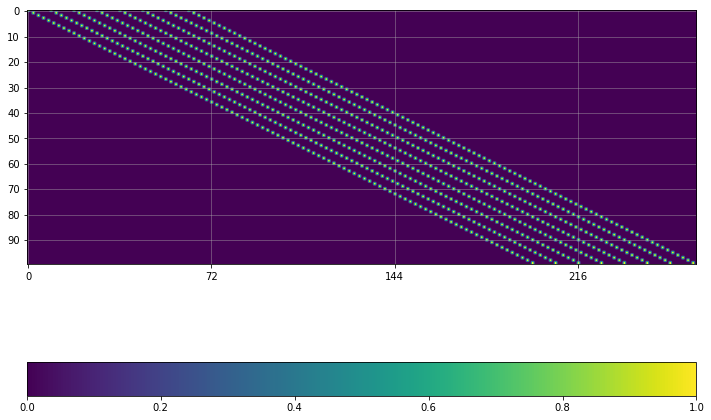

In [446]:
img_size_x = 263 #usually, match with seq_idx[-1][-1]
img_size_y = 100 #number of sequence to visuallize
seq_length_squeeze_ratio = 1

img = np.zeros([img_size_y, img_size_x])

for yidx, seq in enumerate(seqs_idx[:img_size_y]):
    #for i in range(seq[0]//seq_length_squeeze_ratio,seq[-1]//seq_length_squeeze_ratio + 1):
    for i in seq:
        if i<img_size_x:
            img[yidx, i]=1.0

plt.figure(figsize=(12,12))
plt.xticks(ticks=list(range(0,img_size_x,seq_field)))
plt.yticks(ticks=list(range(0,img_size_y,10)))

plt.grid(alpha=0.5)
plt.imshow(img)
plt.colorbar(location='bottom')
plt.show()

figure는 50행(수직축)까지 시퀀스별 time-index(수평축)를 점으로 표시합니다.

## train, test set 구성
먼저 index를 리셋하고 시작합니다..

In [447]:

df_merged.reset_index(inplace=True, drop=True)
#ds0=ds0[df_default_index]
print(df_merged.isna().any().any())
df_merged

False


,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),...,풍향(deg),기온(°C),수온(°C),강수량(mm),풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),적조발생
0,-0.846358,0.903430,-0.460595,-0.297487,-0.124668,-1.539878,0.752017,-0.658575,-0.665820,-0.134178,...,0.586254,-0.442772,-0.243601,-0.150869,-1.353779,1.551810,-0.364254,-0.500266,-0.112367,0.0
1,-0.308964,0.861089,-0.404756,-0.276128,-0.124668,-1.661737,0.652532,-0.588377,-0.620489,-0.134178,...,0.638984,-0.449676,-0.243601,-0.150869,-0.406414,-1.337830,-0.391642,-0.519119,-0.112367,0.0
2,-0.428385,0.945770,-0.348918,-0.297487,-0.124668,-1.448484,0.534960,-0.616456,-0.643154,-0.134178,...,0.691715,-0.456580,-0.243601,-0.150869,-0.161932,1.378432,-0.377948,-0.519119,-0.112367,0.0
3,-0.338819,0.827217,-0.293080,-0.404279,-0.124668,-1.539878,0.652532,-0.546258,-0.665820,-0.134178,...,0.709292,-0.428963,-0.243601,-0.150869,-0.559215,1.386688,-0.323173,-0.519119,-0.112367,0.0
4,0.168719,1.064324,-0.320999,-0.468355,-0.124668,0.074754,0.842458,-0.447980,-0.688485,-0.134178,...,0.753234,-0.401346,-0.262635,-0.150869,0.113109,-1.329574,-0.336867,-0.500266,-0.112367,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50331,-1.712158,0.115895,0.879527,1.218967,-0.124668,-1.082907,-0.405622,0.899828,1.260715,-0.134178,...,0.419274,1.062370,1.222006,-0.150869,-1.537140,-1.329574,0.881887,1.196504,-0.112367,0.0
50332,-1.353896,0.183640,0.893486,1.176250,-0.124668,-0.991512,-0.360402,0.857709,1.238050,-0.134178,...,0.392909,1.103796,1.241040,-0.150869,-1.384339,-1.222244,0.553234,1.026827,-0.112367,0.0
50333,-1.353896,0.454619,0.879527,1.176250,-0.124668,-1.143836,-0.360402,0.857709,1.215385,-0.134178,...,0.805964,1.062370,1.126837,-0.150869,-1.567700,1.477505,0.347826,0.970268,-0.112367,0.0
50334,-1.234475,0.573173,0.837648,1.261684,-0.124668,-1.418019,-0.043860,0.815590,1.215385,-0.134178,...,0.762022,1.034753,1.088769,-0.150869,-1.567700,1.361919,0.690173,0.932562,-0.112367,0.0


In [448]:
df_merged.columns

Index(['풍속(m/s)', '풍향(deg)', '기온(°C)', '수온(°C)', '강수량(mm)', '풍속(m/s)',
       '풍향(deg)', '기온(°C)', '수온(°C)', '강수량(mm)', '풍속(m/s)', '풍향(deg)',
       '기온(°C)', '수온(°C)', '강수량(mm)', '풍속(m/s)', '풍향(deg)', '기온(°C)', '수온(°C)',
       '강수량(mm)', '풍속(m/s)', '풍향(deg)', '기온(°C)', '수온(°C)', '강수량(mm)', '적조발생'],
      dtype='object')

In [449]:
#train_cols=['풍속(m/s)', '풍향(deg)', '기온(°C)', '수온(°C)', '강수량(mm)', '적조발생']
ds_train_cols=df_merged
ds_train_cols.reset_index(inplace=True, drop=True)
ds_train_cols

,풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),...,풍향(deg),기온(°C),수온(°C),강수량(mm),풍속(m/s),풍향(deg),기온(°C),수온(°C),강수량(mm),적조발생
0,-0.846358,0.903430,-0.460595,-0.297487,-0.124668,-1.539878,0.752017,-0.658575,-0.665820,-0.134178,...,0.586254,-0.442772,-0.243601,-0.150869,-1.353779,1.551810,-0.364254,-0.500266,-0.112367,0.0
1,-0.308964,0.861089,-0.404756,-0.276128,-0.124668,-1.661737,0.652532,-0.588377,-0.620489,-0.134178,...,0.638984,-0.449676,-0.243601,-0.150869,-0.406414,-1.337830,-0.391642,-0.519119,-0.112367,0.0
2,-0.428385,0.945770,-0.348918,-0.297487,-0.124668,-1.448484,0.534960,-0.616456,-0.643154,-0.134178,...,0.691715,-0.456580,-0.243601,-0.150869,-0.161932,1.378432,-0.377948,-0.519119,-0.112367,0.0
3,-0.338819,0.827217,-0.293080,-0.404279,-0.124668,-1.539878,0.652532,-0.546258,-0.665820,-0.134178,...,0.709292,-0.428963,-0.243601,-0.150869,-0.559215,1.386688,-0.323173,-0.519119,-0.112367,0.0
4,0.168719,1.064324,-0.320999,-0.468355,-0.124668,0.074754,0.842458,-0.447980,-0.688485,-0.134178,...,0.753234,-0.401346,-0.262635,-0.150869,0.113109,-1.329574,-0.336867,-0.500266,-0.112367,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50331,-1.712158,0.115895,0.879527,1.218967,-0.124668,-1.082907,-0.405622,0.899828,1.260715,-0.134178,...,0.419274,1.062370,1.222006,-0.150869,-1.537140,-1.329574,0.881887,1.196504,-0.112367,0.0
50332,-1.353896,0.183640,0.893486,1.176250,-0.124668,-0.991512,-0.360402,0.857709,1.238050,-0.134178,...,0.392909,1.103796,1.241040,-0.150869,-1.384339,-1.222244,0.553234,1.026827,-0.112367,0.0
50333,-1.353896,0.454619,0.879527,1.176250,-0.124668,-1.143836,-0.360402,0.857709,1.215385,-0.134178,...,0.805964,1.062370,1.126837,-0.150869,-1.567700,1.477505,0.347826,0.970268,-0.112367,0.0
50334,-1.234475,0.573173,0.837648,1.261684,-0.124668,-1.418019,-0.043860,0.815590,1.215385,-0.134178,...,0.762022,1.034753,1.088769,-0.150869,-1.567700,1.361919,0.690173,0.932562,-0.112367,0.0


In [450]:
seq_dataset=np.zeros([len(seqs_idx), len(seqs_idx[0]), len(ds_train_cols.columns)])
seq_dataset.shape

(25133, 8, 26)

In [451]:
for i, seq in enumerate(seqs_idx):
    for j, row_number in enumerate(seq):
        seq_dataset[i, j]=ds_train_cols.loc[row_number].to_numpy()

seq_dataset[:2]

array([[[-0.84635756,  0.9034296 , -0.46059474, -0.29748681,
         -0.12466844, -1.53987786,  0.75201707, -0.65857547,
         -0.66581958, -0.13417772,  0.21336403,  0.51924735,
         -0.47213906, -0.52950636, -0.12181682, -0.02957304,
          0.5862539 , -0.44277185, -0.24360069, -0.1508693 ,
         -1.35377918,  1.55181007, -0.36425441, -0.50026611,
         -0.11236746,  0.        ],
        [ 0.76582223,  0.93730207, -0.53039273, -0.63922284,
         -0.12466844, -0.56500591,  1.14995565, -0.72877382,
         -1.00579623, -0.13417772, -0.54490098,  1.24606092,
         -0.48607266, -0.99300129, -0.12181682,  0.70738233,
          1.2541729 , -0.70513599, -0.33876996, -0.1508693 ,
          0.14366944,  1.4527367 , -0.74768242, -0.44370709,
         -0.11236746,  0.        ],
        [ 0.04929788,  1.16594127, -0.99105944, -0.44699632,
         -0.12466844,  0.53172504,  1.35796899, -1.20612261,
         -0.7111498 , -0.13417772, -0.48171223, -1.54871031,
         -1.0

In [452]:
ds_train_cols.loc[0].to_numpy()

array([-0.84635756,  0.9034296 , -0.46059474, -0.29748681, -0.12466844,
       -1.53987786,  0.75201707, -0.65857547, -0.66581958, -0.13417772,
        0.21336403,  0.51924735, -0.47213906, -0.52950636, -0.12181682,
       -0.02957304,  0.5862539 , -0.44277185, -0.24360069, -0.1508693 ,
       -1.35377918,  1.55181007, -0.36425441, -0.50026611, -0.11236746,
        0.        ])

### label 예외처리: 
이유를 찾지 못했는데 라벨에 0, 1아닌 값들이 있어 임시로 씁니다.

In [453]:
def not_bin_in_occurence(x):
    if x==1 or x==0:
        return x
    else:
        print('exceptional value(not 0 or 1) found. replaced by near one.')
        if x>=0.5:
            return 1
        else:
            return 0
        
ds_train_cols['적조발생']=ds_train_cols['적조발생'].apply(not_bin_in_occurence)

### train - test 셋 분리 :
특정 연도들에 대한 과적합을 없애기 위해 test와 train을 섞지 않고 시계열에서 일단 나눕니다. 그 이후 shuffle합니다.  
셔플 참고자료(stack overflow) https://stackoverflow.com/questions/35646908/numpy-shuffle-multidimensional-array-by-row-only-keep-column-order-unchanged

In [454]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(seq_dataset[:,:,0:-1], seq_dataset[:,:,-1], test_size=0.20, random_state=42)

#1. 8:2 split
split_index=int(len(seq_dataset)*0.8)
print(split_index, len(seq_dataset))

#2. 5:5 split
#split_index=int(len(ds_train_cols)*0.5)
train_xy=seq_dataset[:split_index]
np.random.shuffle(train_xy)
X_train=train_xy[:,:,0:-1]
y_train=train_xy[:,:,-1]

test_xy=seq_dataset[split_index:]
np.random.shuffle(test_xy)
X_test=test_xy[:,:,0:-1]
y_test=test_xy[:,:,-1]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape,'\n\n')


20106 25133
(20106, 8, 25) (5027, 8, 25) (20106, 8) (5027, 8) 




In [455]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape,'\n\n')
print('print data for one sequence')
i=0 #sample index
print('\n X_train is: \n', X_train[i])
print('\n X_test is: \n', X_test[i])
print('\n y_train and y_test are:',y_train[i], y_test[i], sep='\n')

(20106, 8, 25) (5027, 8, 25) (20106, 8) (5027, 8) 


print data for one sequence

 X_train is: 
 [[ 1.54205695e+00  1.41298941e-01  7.95769012e-01 -1.26618796e-01
   6.97999441e-01  7.47538087e-02 -7.40252574e-01  3.66320448e-01
   1.27459274e-01  8.14543205e+00  1.63511093e+00 -5.88278091e-01
   3.77810210e-01  1.10558074e-01  2.84936057e+01  1.22939238e+00
  -3.77230570e-02  7.44771089e-01  2.89347205e-01  2.02104811e+01
   5.40951722e-01  3.79441824e-01  6.49091050e-01  8.76505979e-03
   1.16498763e+00]
 [ 1.48234658e+00  4.46151205e-01  4.04900288e-01 -3.61562314e-01
  -1.24668440e-01 -7.47794401e-01  1.25848435e+00  3.94399788e-01
   3.08780155e-01 -1.34177724e-01 -4.18523481e-01 -8.56506910e-01
   3.77810210e-01  2.22733253e-02  2.45047572e-01 -7.97234877e-01
   3.75332112e-01  3.85746478e-01  9.90086709e-02 -1.50869302e-01
   1.73279858e+00  1.08121155e+00  2.93050754e-01 -1.04352977e-01
  -1.12367457e-01]
 [ 1.39278104e+00  7.25599113e-01  1.11748745e-01 -4.89713324e-01
  -1.24

### y_test의 label 불균형:
적조 label의 비율은 0.0902로 0만 내도 accuracy 90.8%가 나온다.


In [456]:
print(y_test.sum().sum(), y_test.shape)
print(y_test.sum().sum()/(y_test.shape[0]*y_test.shape[1]))

3628.0 (5027, 8)
0.0902128506067237


# model & train
간단한 LSTM 모델을 트레인 해봅니다.
let's train simple LSTM model

In [466]:
from tensorflow import keras
from tensorflow.keras import layers


In [491]:

model = keras.Sequential([
    keras.Input(shape=(8, 25)),
    layers.LSTM(32),
    layers.Dense(8, activation="sigmoid"),
]
)

In [492]:
#copied from:
#https://www.dacon.io/competitions/official/235584/codeshare/738
def seq_acc(y_true, y_pred):
    y_bin=np.zeros_like(y_pred)
    for i, dd in enumerate(y_bin):
        for j in range(len(dd)):
            pred=y_pred[i][j]
            if pred>=0.5:
                y_bin[i][j]=1
            else:
                y_bin[i][j]=0
            
    predict_true = (y_true == y_bin)
    # multi-column일 경우에도 계산 할 수 있도록 np.average를 한번 더 씌움
    try:
        score = np.average(np.average(predict_true))
    except ValueError:
        score = mean_squared_error(y_true, y_bin)
    return score

def my_seq_acc(y_true, y_pred):
    score = tf.py_function(func=seq_acc, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_seq_acc') # tf 2.x
    #score = tf.py_func( lambda y_true, y_pred : mse_AIFrenz(y_true, y_pred) , [y_true, y_pred], 'float32', stateful = False, name = 'custom_mse' ) # tf 1.x
    return score


In [493]:
model.compile(optimizer="adam", loss="binary_crossentropy")

In [494]:
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 32)                7424      
_________________________________________________________________
dense_33 (Dense)             (None, 8)                 264       
Total params: 7,688
Trainable params: 7,688
Non-trainable params: 0
_________________________________________________________________


In [495]:
history = model.fit(X_train, y_train, batch_size=32, epochs=3, validation_data=(X_test, y_test))

Epoch 1/3
629/629 [==============================] - 4s 4ms/step - loss: 0.1780 - val_loss: 0.2120
Epoch 2/3
629/629 [==============================] - 2s 3ms/step - loss: 0.0926 - val_loss: 0.1685
Epoch 3/3
629/629 [==============================] - 2s 3ms/step - loss: 0.0729 - val_loss: 0.1648


In [496]:
print(history.history['loss'])
print(history.history['val_loss'])


[0.17800740897655487, 0.09259165078401566, 0.07285550981760025]
[0.21202008426189423, 0.1685064285993576, 0.16475404798984528]


In [497]:
y_pred=model.predict(X_test)
print(seq_acc(y_test, y_pred))

0.9261239307738214


In [498]:
del model

In [177]:
#it arbitrary chosen from some execution.
#just included label = 1 case and label = 0 case

#X_sample=X_test[100:120:10]
#y_sample=y_test[100:120:10]
print('predicted value: ', model.predict(X_sample),sep='\n')
print()
print('label: ', y_sample, sep='\n')

predicted value: 
[[9.1334878e-06 9.2947457e-06 7.8261437e-06 6.4386145e-06 4.6694545e-06
  3.7069281e-06 4.5941997e-06 8.6771061e-06]
 [8.5355681e-01 9.0191513e-01 9.1080046e-01 9.0852207e-01 8.8932794e-01
  9.0266711e-01 9.2417014e-01 9.3287802e-01]]

label: 
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1.]]


### 결과 분석: 

2022-11-07 이전  
50, 52행은 모두 적조가 발생하지 않았고, 51행은 적조 중이었습니다. 나름 그럴싸하게 나오지만..
label 대부분이 0인 것을 생각하면 별 의미가 없습니다.

# 앞으로 할 일:
- 5지점 데이터 활용하기 : 지금은 통영만 사용함
- 모델 고도화 : 테스트 삼아서 필수적인 레이어만 넣어본 것입니다.
- 인풋 데이터 : normalization (평균 0 만들기, 편차 맞추기)
- 라벨 편향에 의한 영향 분석